# Set-up

In [27]:
#pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
    --------------------------------------- 1.9/99.7 MB 41.6 MB/s eta 0:00:03
   - -------------------------------------- 4.4/99.7 MB 55.7 MB/s eta 0:00:02
   --- ------------------------------------ 7.5/99.7 MB 60.0 MB/s eta 0:00:02
   ---- ----------------------------------- 10.2/99.7 MB 59.7 MB/s eta 0:00:02
   ----- ---------------------------------- 12.9/99.7 MB 65.6 MB/s eta 0:00:02
   ------ --------------------------------- 15.6/99.7 MB 59.5 MB/s eta 0:00:02
   ------- -------------------------------- 18.4/99.7 MB 59.5 MB/s eta 0:00:02
   -------- ------------------------------- 21.0/99.7 MB 59.5 MB/s eta 0:00:02
   --------- ------------------------------ 24.3/99.7 MB 59.5 MB/s eta 0:00:02
   ---------- ---

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Dataset

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [33]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Preparing the dataset

In [34]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [35]:
# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [36]:
#Fill missing values with zeros.
df.fillna(0, inplace=True)

C:\Users\Iñigo\AppData\Local\Temp\ipykernel_30832\3683026017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [37]:
#Do train/validation/test split with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
    

In [38]:
#Use DictVectorizer(sparse=True) to turn the dataframes into matrices
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')


In [39]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Question 1

In [40]:
# Let's train a decision tree regressor to predict the median_house_value variable. Train a model with max_depth=1.
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [41]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# Question 2

In [42]:
#Train a random forest model with these parameters:

#n_estimators=10
#random_state=1
#n_jobs=-1 (optional - to make training faster)

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [43]:
# Calcualate RMSE for the validation dataset. 

y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 0.24459962783255346


# Question 3

In [44]:
#Try different values of this parameter from 10 to 200 with step 10.
#Set random_state to 1.
#Evaluate the model on the validation dataset

scores = []
for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append((n, rmse))

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
# After which value of n_estimators does RMSE stop improving
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])


<Axes: xlabel='n_estimators'>

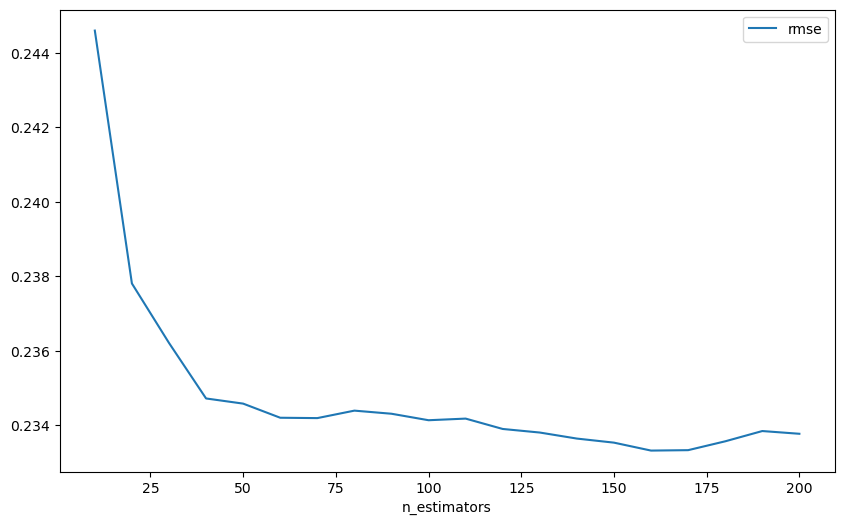

In [46]:
df_scores.plot(x='n_estimators', y='rmse', figsize=(10, 6))

# Question 4

In [47]:
# Try different values of max_depth: [10, 15, 20, 25]
#For each of these values,
#try different values of n_estimators from 10 till 200 (with step 10)
#calculate the mean RMSE
#Fix the random seed: random_state=1

scores = []
for d in [10, 15, 20, 25]:
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        scores.append((d, n, rmse))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [48]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

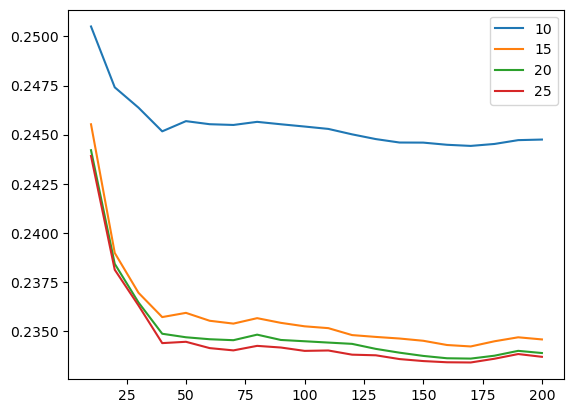

In [49]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

# Question 5

In [50]:
#Train a decision tree with these parameters:
#n_estimators=10,
#max_depth=20,
#random_state=1,
#n_jobs=-1 (optional)
#Get the feature importance information from this model

rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

#Get the feature importance information from this model
importances = rf.feature_importances_
importances


array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [51]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.015043
1,housing_median_age,0.030063
2,latitude,0.102665
3,longitude,0.085853
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
7,population,0.028115
8,total_bedrooms,0.015434
9,total_rooms,0.021062


In [52]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853


# Question 6

In [53]:
#Install XGBoost
#Create DMatrix for train and validation
#Create a watchlist
#Train a model with these parameters for 100 rounds:
#xgb_params = {
#    'eta': 0.3, 
#    'max_depth': 6,
#   'min_child_weight': 1,
    
#    'objective': 'reg:squarederror',
#    'nthread': 8,
    
#    'seed': 1,
#    'verbosity': 1,
#}

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)



In [54]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [55]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [60]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [61]:
scores['eta=0.1'] = parse_xgb_output(output)

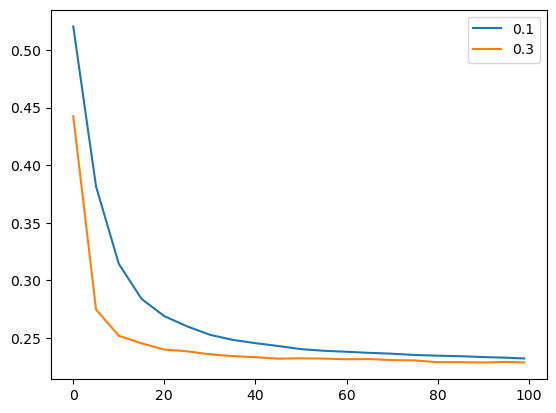

In [62]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()